## Atividade da aula 05

### Minha Hipótese Escolhida

1.Acesso e evasão

Estudantes com Acesso_Internet “Ruim/Instável” apresentam maior risco de evasão (Risco_Evasao =
1), mesmo quando considerados fatores de rotina (ex.: Faltas_Percentual,
Trabalho_Horas_Semanais, Deslocamento_Minutos).

– Tarefa: Classificação com KNN para Risco_Evasao; comparar k∈{3,5,11,21}, distância Euclidiana vs.
Manhattan; analisar matriz de confusão por estratos de acesso à internet.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### Chegagem junto com a carga de dados

In [4]:
# Ler dados
df = pd.read_csv('dataset_educacao_graduacao_brasil_500.csv')

# Chegagem de dados
display(df.head())
display(df.info())
df.describe(include='all').T
df.isna().mean().sort_values(ascending=False).head(20)

,Regiao,Localidade,Cidade_Tamanho,Tipo_IES,Modalidade,Periodo,Area,Genero,Cor_Raca,Idade,...,Nota_ENEM,Faltas_Percentual,CRA,Reprovacoes,Engajamento_Plataformas_h_sem,Estagio,Monitoria,Duracao_Curso_Semestres,Semestre_Atual,Risco_Evasao
0,Sul,Interior,Média,Privada,Presencial,Noturno,Licenciaturas,Feminino,Parda,20,...,714,15.3,6.28,0,6.3,0,0,10,6,0
1,Centro-Oeste,Interior,Pequena,Privada,EAD,Vespertino,Humanas,Masculino,Branca,20,...,571,3.5,7.52,1,7.6,0,0,12,5,0
2,Sudeste,Interior,Grande,Privada,Híbrido,Integral,Saúde,Feminino,Parda,24,...,522,20.4,3.73,0,4.5,0,0,8,1,0
3,Sudeste,Interior,Metrópole,Privada,Presencial,Vespertino,Sociais Aplicadas,Masculino,Parda,21,...,540,17.9,5.06,2,8.2,0,0,8,7,0
4,Sul,Capital,Média,Privada,EAD,Matutino,Engenharias,Feminino,Branca,17,...,662,10.3,7.83,0,19.9,1,0,10,4,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Regiao                         500 non-null    object 
 1   Localidade                     500 non-null    object 
 2   Cidade_Tamanho                 500 non-null    object 
 3   Tipo_IES                       500 non-null    object 
 4   Modalidade                     500 non-null    object 
 5   Periodo                        500 non-null    object 
 6   Area                           500 non-null    object 
 7   Genero                         500 non-null    object 
 8   Cor_Raca                       500 non-null    object 
 9   Idade                          500 non-null    int64  
 10  Renda_Familiar_SM              500 non-null    float64
 11  Escola_Medio                   500 non-null    object 
 12  Acesso_Internet                500 non-null    obj

None

Regiao                        0.0
Localidade                    0.0
Cidade_Tamanho                0.0
Tipo_IES                      0.0
Modalidade                    0.0
Periodo                       0.0
Area                          0.0
Genero                        0.0
Cor_Raca                      0.0
Idade                         0.0
Renda_Familiar_SM             0.0
Escola_Medio                  0.0
Acesso_Internet               0.0
Dispositivo_Estudo            0.0
Bolsa_ou_Financiamento        0.0
Horas_Estudo_Semanais         0.0
Trabalho_Horas_Semanais       0.0
Deslocamento_Minutos          0.0
Dificuldade_Financeira_1a5    0.0
Saude_Mental_1a5              0.0
dtype: float64

#### Pré-processamento

In [18]:
# Seleção de features e target
TARGET = "Risco_Evasao"
ESTRATO = "Acesso_Internet"

# Definição de features
features = [
 "Trabalho_Horas_Semanais", "Deslocamento_Minutos",
    "Idade", "Renda_Familiar_SM", "Modalidade", "Tipo_IES",
    ESTRATO
]

# Divisão entre features e target
X = df[features].copy()
y = df[TARGET].copy()


# Identificar tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_cols, cat_cols

(['Trabalho_Horas_Semanais',
  'Deslocamento_Minutos',
  'Idade',
  'Renda_Familiar_SM'],
 ['Modalidade', 'Tipo_IES', 'Acesso_Internet'])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# transformers
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    remainder="drop"
)

#### Split treino/teste

In [20]:

# split 70/30 estratificado no alvo 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((350, 7),
 (150, 7),
 Risco_Evasao
 0    0.72
 1    0.28
 Name: proportion, dtype: float64,
 Risco_Evasao
 0    0.72
 1    0.28
 Name: proportion, dtype: float64)

#### Modelagem de KNN

In [ ]:
from sklearn.metrics import accuracy_score

ks = list(range(1, 32, 2)) 
metrics = ["euclidean", "manhattan"]

curvas = {}  

for metric in metrics:
    acc_train_list, acc_test_list = [], []
    for k in ks:
        pipe = Pipeline(steps=[
            ("prep", preprocess),
            ("knn", KNeighborsClassifier(n_neighbors=k, metric=metric))
        ])
        pipe.fit(X_train, y_train)

        # scores de treino e teste
        acc_train = pipe.score(X_train, y_train)
        acc_test  = pipe.score(X_test,  y_test)

        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)

    curvas[metric] = pd.DataFrame({
        "k": ks,
        "acc_train": acc_train_list,
        "acc_test": acc_test_list
    })

for metric in metrics:
    display(metric, curvas[metric].round(4))


'euclidean'

,k,acc_train,acc_test
0,1,1.0000,0.6467
1,3,0.8086,0.6933
2,5,0.7686,0.7133
3,7,0.7486,0.6933
4,9,0.7686,0.7333
5,11,0.7543,0.7333
6,13,0.7486,0.7267
7,15,0.7486,0.7133
8,17,0.7486,0.7267
9,19,0.7400,0.7333


'manhattan'

,k,acc_train,acc_test
0,1,1.0000,0.6867
1,3,0.8143,0.7067
2,5,0.7771,0.7067
3,7,0.7657,0.6867
4,9,0.7514,0.7200
5,11,0.7600,0.7200
6,13,0.7514,0.7333
7,15,0.7486,0.7600
8,17,0.7486,0.7600
9,19,0.7457,0.7467


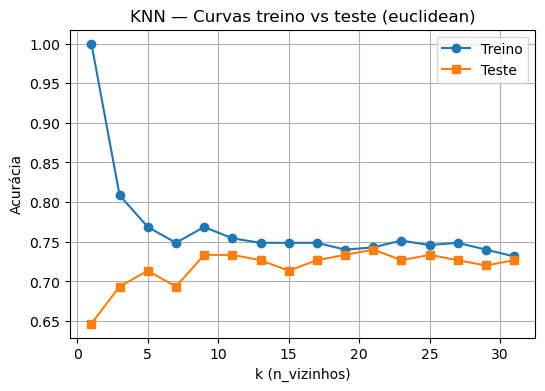

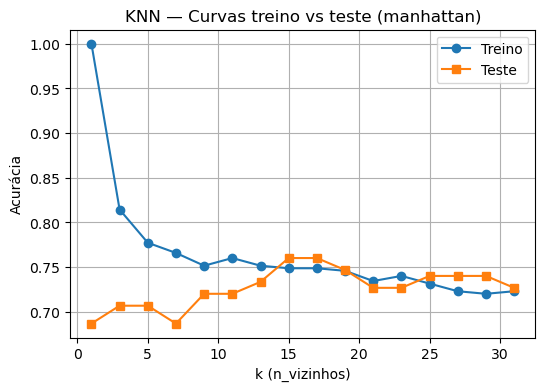

In [22]:
for metric in metrics:
    dfm = curvas[metric]
    plt.figure(figsize=(6,4))
    plt.plot(dfm["k"], dfm["acc_train"], marker="o", label="Treino")
    plt.plot(dfm["k"], dfm["acc_test"],  marker="s", label="Teste")
    plt.xlabel("k (n_vizinhos)")
    plt.ylabel("Acurácia")
    plt.title(f"KNN — Curvas treino vs teste ({metric})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
melhores = []
for metric in metrics:
    idx = curvas[metric]["acc_test"].idxmax()
    best_k = int(curvas[metric].loc[idx, "k"])
    best_acc_test = float(curvas[metric].loc[idx, "acc_test"])
    melhores.append((metric, best_k, best_acc_test))

melhores_sorted = sorted(melhores, key=lambda x: x[2], reverse=True)
best_metric, best_k, best_acc = melhores_sorted[0]
best_metric, best_k, round(best_acc,4)

('manhattan', 15, 0.76)

#### Avaliação

A métrica de distância Manhattan demonstrou um ajuste superior ao dataset. Enquanto a distância Euclidiana apresentou maior instabilidade e um score de teste de aproximadamente 0.74, a Manhattan alcançou um pico de 0.75 com uma curva mais estável e uma menor diferença entre os resultados de treino e teste.

#### Treino do Modelo Final

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score

modelo_final = Pipeline(steps=[
    ("prep", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=best_k, metric=best_metric))
])
modelo_final.fit(X_train, y_train)

y_pred = modelo_final.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print(f"Métrica = {best_metric} | k = {best_k}")
print(f"Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f}")
print(f"Precision(1): {prec:.4f} | Recall(1): {rec:.4f} | F1(1): {f1:.4f}")
print("\nMatriz de confusão:\n", cm)
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

Métrica = manhattan | k = 15
Acurácia: 0.7600 | Balanced Acc: 0.5933
Precision(1): 0.7500 | Recall(1): 0.2143 | F1(1): 0.3333

Matriz de confusão:
 [[105   3]
 [ 33   9]]

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.7609    0.9722    0.8537       108
           1     0.7500    0.2143    0.3333        42

    accuracy                         0.7600       150
   macro avg     0.7554    0.5933    0.5935       150
weighted avg     0.7578    0.7600    0.7080       150



#### Análises por subgrupos

In [25]:
X_test_view = X_test.copy()
X_test_view["y_true"] = y_test.values
X_test_view["y_pred"] = y_pred

cats = X_test_view[ESTRATO].dropna().unique().tolist()
for cat in cats:
    sub = X_test_view[X_test_view[ESTRATO] == cat]
    if sub.empty: 
        continue
    cm_cat = confusion_matrix(sub["y_true"], sub["y_pred"])
    ba_cat = balanced_accuracy_score(sub["y_true"], sub["y_pred"])
    f1_cat = f1_score(sub["y_true"], sub["y_pred"], zero_division=0)
    print(f"\n=== {ESTRATO} = {cat} (n={len(sub)}) ===")
    print("Matriz de confusão:\n", cm_cat)
    print(f"Balanced Acc: {ba_cat:.4f} | F1(1): {f1_cat:.4f}")



=== Acesso_Internet = Boa (n=71) ===
Matriz de confusão:
 [[51  3]
 [13  4]]
Balanced Acc: 0.5899 | F1(1): 0.3333

=== Acesso_Internet = Ruim (n=27) ===
Matriz de confusão:
 [[17  0]
 [ 8  2]]
Balanced Acc: 0.6000 | F1(1): 0.3333

=== Acesso_Internet = Instável (n=52) ===
Matriz de confusão:
 [[37  0]
 [12  3]]
Balanced Acc: 0.6000 | F1(1): 0.3333


In [26]:
def group_access(x: str):
    if pd.isna(x):
        return "Desconhecido"
    s = str(x).lower()
    if "ruim" in s or "instavel" in s or "instável" in s:
        return "Ruim/Instável"
    return "Outros"

X_test_view["Grupo_Acesso"] = X_test_view[ESTRATO].apply(group_access)
for g, sub in X_test_view.groupby("Grupo_Acesso"):
    cm_g = confusion_matrix(sub["y_true"], sub["y_pred"])
    ba_g = balanced_accuracy_score(sub["y_true"], sub["y_pred"])
    f1_g = f1_score(sub["y_true"], sub["y_pred"], zero_division=0)
    print(f"\n=== Grupo {g} (n={len(sub)}) ===")
    print("Matriz de confusão:\n", cm_g)
    print(f"Balanced Acc: {ba_g:.4f} | F1(1): {f1_g:.4f}")



=== Grupo Outros (n=71) ===
Matriz de confusão:
 [[51  3]
 [13  4]]
Balanced Acc: 0.5899 | F1(1): 0.3333

=== Grupo Ruim/Instável (n=79) ===
Matriz de confusão:
 [[54  0]
 [20  5]]
Balanced Acc: 0.6000 | F1(1): 0.3333


In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

TARGET_REG = "CRA"
y_reg = df[TARGET_REG].copy()
X_reg = df[features].copy()

Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.30, random_state=RANDOM_STATE)

reg_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("knn", KNeighborsRegressor(n_neighbors=5, metric="euclidean"))
]).fit(Xtr, ytr)

ypred = reg_pipe.predict(Xte)
mae = mean_absolute_error(yte, ypred)
mse = mean_squared_error(yte, ypred)
rmse = np.sqrt(mse)
r2 = r2_score(yte, ypred)
mae, rmse, r2


(0.8006266666666666, np.float64(1.0194811360033431), 0.298709650346373)

#### Conclusão

A avaliação do classificador KNN revelou uma acurácia total de 76%. No entanto, a métrica de recall para a classe de evasão foi de apenas 21%, o que aponta para uma deficiência do modelo em sua tarefa de identificar corretamente os alunos em situação de risco.